In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
import numba
import coffea.hist as hist

In [2]:
infile = "data/signal/wza_UL18.root" # --signal
#infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root' # --data 
#infile = 'data/data/CA42F3A2-614F-4A4F-AF18-F6E66CDA2C85_skim_2ElIdPt20.root'
#infile = 'data/Ntuple/EGamma_Run2018B.root'
#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root" # --mc


year='2018'

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set
doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',    # Recomended
        ]
    }

In [5]:
# << flat dim helper function >>
def flat_dim(arr):

#   if len(ak.to_numpy(arr).shape) > 1:
#       sub_arr = ak.flatten(arr)
#   else:
#       sub_arr = arr
    sub_arr = ak.flatten(arr)
    mask = ~ak.is_none(sub_arr)

    return ak.to_numpy(sub_arr[mask])
# << drop na helper function >>
def drop_na(arr):

    mask = ~ak.is_none(arr)

    return arr[mask]
# << drop na helper function >>
def drop_na_np(arr):

    mask = ~np.isnan(arr)

    return arr[mask]
# << Sort by PT  helper function >>
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet

In [6]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

# Sort particle order by PT  # RunD --> has problem
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

Initial_events = events
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]

cut1 = np.ones(len(events))
# Particle Identification
Electron = events.Electron
Photon = events.Photon
MET = events.MET


In [7]:
print("#### 0. Trigger: {0} -> {1}".format(len(Initial_events), len(events)))

#### 0. Trigger: 55000 -> 9544


### 1. Channel selection with basic cut applied (without ID)

In [8]:
def Particle_selection(ele,pho):


    EleSelmask = EleSelmask = ((ele.pt > 10) & (np.abs(ele.eta + ele.deltaEtaSC) < 1.4442) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.05) & (abs(ele.dz) < 0.1)) | \
        ((ele.pt > 10) & (np.abs(ele.eta + ele.deltaEtaSC) > 1.5660) & (np.abs(ele.eta + ele.deltaEtaSC) < 2.5) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.1) & (abs(ele.dz) < 0.2))


    # Photon selection
    isgap_mask = (abs(pho.eta) < 1.442)  |  ((abs(pho.eta) > 1.566) & (abs(pho.eta) < 2.5))
    Pixel_seed_mask = ~pho.pixelSeed
    PhoSelmask = (pho.pt > 20) & isgap_mask &  Pixel_seed_mask
    #PhoSelmask = (pho.pt > 20) & (pho.cutBased > 1) & isgap_mask &  Pixel_seed_mask # with cut-based ID


    return EleSelmask,PhoSelmask

In [9]:
Electron_mask, Photon_mask  = Particle_selection(Electron,Photon)
Ele_channel_mask = ak.num(Electron[Electron_mask])  > 1
Pho_channel_mask = ak.num(Photon[Photon_mask]) > 0
Ele_channel_events = events[Ele_channel_mask & Pho_channel_mask]

In [10]:
print("#### 1. Channel selection with basic cut applied {0}->{1} {2}%".format(len(events),len(Ele_channel_events), len(Ele_channel_events)/len(events) * 100))

#### 1. Channel selection with basic cut applied 9544->3223 33.7699077954736%


In [11]:
# Particle array
Electron = Ele_channel_events.Electron
Photon  = Ele_channel_events.Photon
Jet     = Ele_channel_events.Jet
MET      = Ele_channel_events.MET

Electron_mask,Photon_mask = Particle_selection(Electron,Photon)
Electron = Electron[Electron_mask]
Photon  = Photon[Photon_mask]

### 2. Select OSSF electron pairs

In [12]:
##-----------  Cut flow3: Electron Selection --> OSSF 
# OSSF index maker
@numba.njit
def find_2lep(events_leptons,builder):
    for leptons in events_leptons:

        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0+1,nlep):
                if leptons[i0].charge + leptons[i1].charge != 0: continue;
                
                if nlep == 2:
                    builder.begin_tuple(2)
                    builder.index(0).integer(i0)
                    builder.index(1).integer(i1)
                    builder.end_tuple()  

            
                else:
                    for i2 in range(nlep):
                        if len({i0,i1,i2}) < 3: continue;
                        builder.begin_tuple(3)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.end_tuple()
        builder.end_list()
    return builder

In [13]:
ossf_idx = find_2lep(Electron,ak.ArrayBuilder()).snapshot()
ossf_idx

<Array [[], [(0, 1)], [(0, ... 1)], [(0, 1)]] type='3223 * var * union[(int64, i...'>

In [14]:
# OSSF cut
ossf_mask = ak.num(ossf_idx) >= 1
ossf_idx = ossf_idx[ossf_mask]

Ele_channel_events = Ele_channel_events[ossf_mask]
Electron= Electron[ossf_mask]
Photon= Photon[ossf_mask]
Jet= Jet[ossf_mask]
MET = MET[ossf_mask]

In [15]:
print("#### 2. OSSF {0}".format(len(Ele_channel_events)))

#### 2. OSSF 2546


In [16]:
Double_electron = [Electron[ossf_idx[idx]] for idx in "01"]

In [17]:
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

def TLorentz_vector(vec):
    vec = ak.zip(
    {
                "x":vec.x,
                "y":vec.y,
                "z":vec.z,
                "t":vec.t
    },
    with_name = "LorentzVector"
    )
    return vec

def TLorentz_vector_cylinder(vec):

    vec = ak.zip(
    {
         "pt": vec.pt,
         "eta": vec.eta,
         "phi": vec.phi,
         "mass": vec.mass,
    },
    with_name="PtEtaPhiMLorentzVector",
    )

    return vec


In [18]:
Diele    = ak.zip({"lep1":Double_electron[0],
                   "lep2":Double_electron[1],
                     "p4":TLorentz_vector(Double_electron[0]+Double_electron[1])})

In [19]:
bestZ_idx = ak.singletons(ak.argmin(abs(Diele.p4.mass - 91.1876), axis=1))
Diele = Diele[bestZ_idx]

leading_ele, subleading_ele  = ak.flatten(TLorentz_vector_cylinder(Diele.lep1)),ak.flatten(TLorentz_vector_cylinder(Diele.lep2))

### Test 3dim hist 

In [20]:
len(Photon[:,0])

2546

In [21]:
ak.max(Photon[:,0].pt)

742.60925

In [22]:
ak.max(Photon[:,0].eta)

2.4990234

In [23]:
ak.max(Photon[:,0].sieie)

0.060302734

In [24]:
def make_bins(pt,eta,sieie,bin_range_str):

        bin_dict = {'PT_1_eta_1' : ( pt > 20 ) & ( pt < 30 ) & ( eta < 1) 
        ,'PT_1_eta_2' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_1_eta_3' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_1_eta_4' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_2_eta_1' : ( pt > 30 ) & ( pt < 40 ) & ( eta < 1) 
        ,'PT_2_eta_2' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_2_eta_3' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_2_eta_4' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_3_eta_1' : ( pt > 40 ) & ( pt < 50 ) & ( eta < 1) 
        ,'PT_3_eta_2' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_3_eta_3' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_3_eta_4' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_4_eta_1' :  ( pt > 50 ) & ( eta < 1) 
        ,'PT_4_eta_2' :  ( pt > 50 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_4_eta_3' :  ( pt > 50 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_4_eta_4' :  ( pt > 50 ) & ( eta > 2) & ( eta < 2.5 )
        }
    
        binmask = bin_dict[bin_range_str]
        
        return ak.to_numpy(sieie[binmask])

In [25]:
photon = Photon[:,0]

In [26]:
photon

<PhotonArray [Photon, Photon, ... Photon, Photon] type='2546 * photon'>

In [27]:
bin_name_list = ['PT_1_eta_1' ,'PT_1_eta_2' ,'PT_1_eta_3' ,'PT_1_eta_4' 
                 ,'PT_2_eta_1' ,'PT_2_eta_2' ,'PT_2_eta_3' ,'PT_2_eta_4' ,'PT_3_eta_1' ,'PT_3_eta_2' 
                 ,'PT_3_eta_3' ,'PT_3_eta_4' ,'PT_4_eta_1' ,'PT_4_eta_2' ,'PT_4_eta_3' ,'PT_4_eta_4']

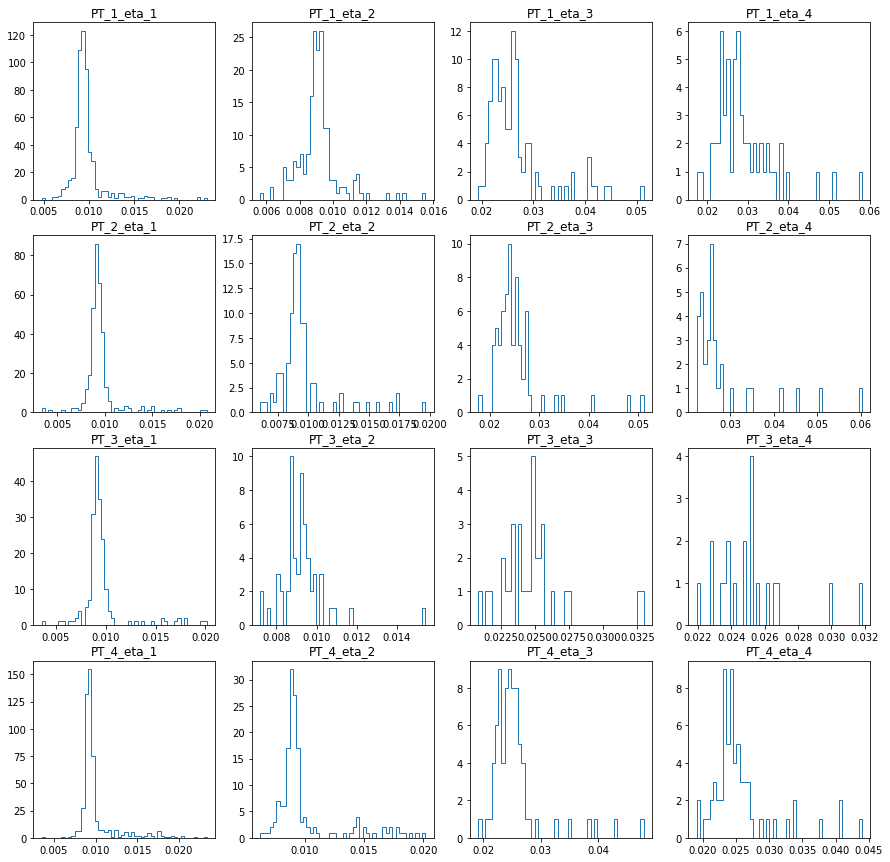

In [28]:
fig,axs = plt.subplots(4,4,figsize=(15,15))
axs = axs.ravel()

for ith,name in enumerate(bin_name_list):
    
    axs[ith].hist(make_bins(photon.pt,abs(photon.eta),photon.sieie,name),bins=50,histtype='step')
    axs[ith].set_title(name)

In [29]:
##-----------  Cut flow4: Photon "cleaning"  -- Basis of array-dimension
def make_DR(ele1,ele2,pho,jet):

    dR_e1pho  = ele1.delta_r(pho) # dR pho,ele1
    dR_e2pho  = ele2.delta_r(pho) # dR pho,ele2
    dR_phojet = jet[:,0].delta_r(pho) # dR pho,jet # #--> Need check

    #dR_mask    = (dR_e1pho > 0.4) & (dR_e2pho > 0.4)&  (dR_e3pho > 0.4) & (dR_phojet > 0.4) #--> Need check
    dR_mask = (dR_e1pho > 0.4) & (dR_e2pho > 0.4)

    #return dR_mask,dR_e1pho,dR_e2pho,dR_e3pho,dR_phojet #--> Need check
    return dR_mask,dR_e1pho,dR_e2pho,dR_phojet

In [30]:
dR_mask,dR_e1pho,dR_e2pho,dR_phojet  = make_DR(leading_ele,subleading_ele,Photon,Jet)
Photon = Photon[dR_mask]

In [31]:
Ele_channel_events  = Ele_channel_events[ak.num(Photon) > 0]
Diele               = Diele[ak.num(Photon) > 0]
Jet                 = Jet[ak.num(Photon) > 0]
MET                 = MET[ak.num(Photon) > 0]
Photon              = Photon[ak.num(Photon) > 0] # Beware the order! Photon must be located last!

In [32]:
print("#### 3. Photon dR {0}".format(len(Ele_channel_events)))

#### 3. Photon dR 2325


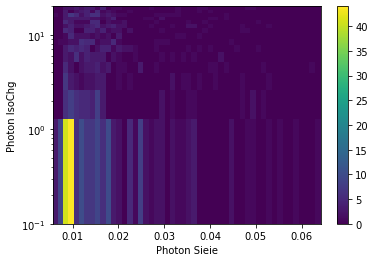

In [99]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

h = ax.hist2d(flat_dim(Photon.sieie),flat_dim(Photon.pfRelIso03_chg * Photon.pt),bins=(50,100))
plt.xlabel('Photon Sieie')
plt.ylim(0.1,20)
plt.yscale('log')
plt.ylabel('Photon IsoChg')
fig.colorbar(h[3],ax=ax)
plt.show()

---

### 5. Event Selection

In [108]:
##-----------  Cut flow5 and 6: Event Selection

# bjet veto
bJet_selmask = (Jet.btagCMVA > -0.5844)
bJet_veto    = ak.num(Jet[bJet_selmask])==0
cut5 = np.ones(ak.sum(ak.num(leading_pho[bJet_veto] > 0 ))) * 5

# Z mass window
zmass_window_mask = ak.firsts((Diele.p4.mass) > 60 | (Diele.p4.mass < 120))

# M(eea) cuts 
eeg_vec           = Diele.p4 + leading_pho
Meeg_mask         = ak.firsts(eeg_vec.mass > 120)

# Mask
Event_sel_mask   = bJet_veto & zmass_window_mask & Meeg_mask

Diele_sel   = Diele[Event_sel_mask]

leading_pho_sel   = leading_pho[Event_sel_mask]
# Photon  EE and EB

isEE_mask = leading_pho.isScEtaEE
isEB_mask = leading_pho.isScEtaEB
Pho_EE = leading_pho[isEE_mask & Event_sel_mask]
Pho_EB = leading_pho[isEB_mask & Event_sel_mask]

MET_sel           = MET[Event_sel_mask]

In [109]:
print("#### 5. Event selection: {0}".format(len(Diele_sel)))

#### 5. Event selection: 10


In [110]:
leading_pho_sel 

<PhotonArray [[Photon], [Photon, ... [Photon]] type='10 * option[var * photon]'>

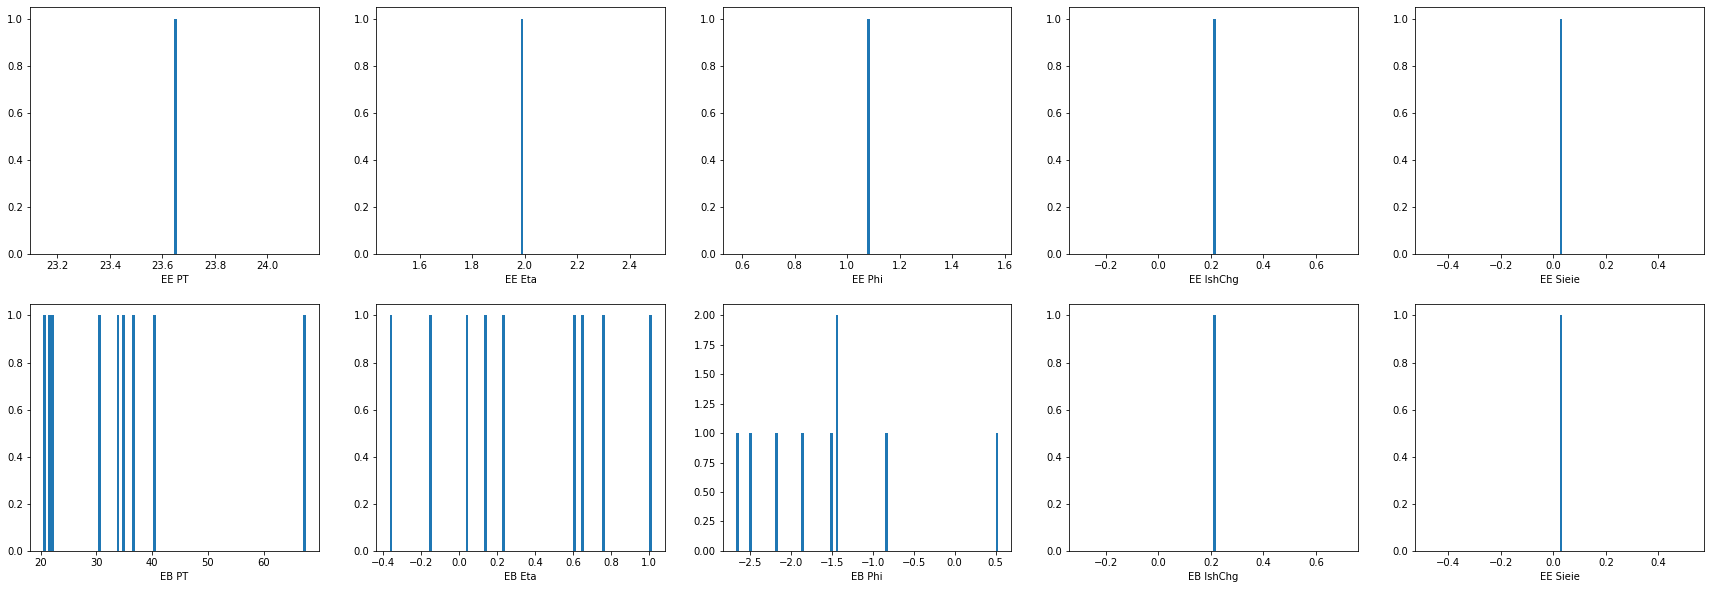

In [35]:
Pho_EE_pt     = flat_dim(Pho_EE.pt)
Pho_EE_eta    = flat_dim(Pho_EE.eta)
Pho_EE_phi    = flat_dim(Pho_EE.phi)
Pho_EE_Isochg = flat_dim(Pho_EE.pfRelIso03_chg)
Pho_EE_Sieie  = flat_dim(Pho_EE.sieie)


Pho_EB_pt  = flat_dim(Pho_EB.pt)
Pho_EB_eta = flat_dim(Pho_EB.eta)
Pho_EB_phi = flat_dim(Pho_EB.phi)
Pho_EB_Isochg = flat_dim(Pho_EE.pfRelIso03_chg)
Pho_EB_Sieie  = flat_dim(Pho_EE.sieie)


Diele_mass = flat_dim(Diele_sel.p4.mass)
eeg_vec = Diele_sel.p4 + leading_pho_sel
eeg_mass = flat_dim(eeg_vec.mass)

Ele1_pt  = flat_dim(Diele_sel.lep1.pt)
Ele1_eta = flat_dim(Diele_sel.lep1.eta)
Ele1_phi = flat_dim(Diele_sel.lep1.phi)

Ele2_pt  = flat_dim(Diele_sel.lep2.pt)
Ele2_eta = flat_dim(Diele_sel.lep2.eta)
Ele2_phi = flat_dim(Diele_sel.lep2.phi)
fig,axs = plt.subplots(2,5,figsize=(30,10))
bins=100

axs[0,0].hist(Pho_EE_pt,bins=bins)
axs[0,0].set_xlabel('EE PT')
axs[0,1].hist(Pho_EE_eta,bins=bins)
axs[0,1].set_xlabel('EE Eta')
axs[0,2].hist(Pho_EE_phi,bins=bins)
axs[0,2].set_xlabel('EE Phi')
axs[0,3].hist(Pho_EE_Isochg,bins=bins)
axs[0,3].set_xlabel('EE IshChg')
axs[0,4].hist(Pho_EE_Sieie,bins=bins)
axs[0,4].set_xlabel('EE Sieie')

axs[1,0].hist(Pho_EB_pt,bins=bins)
axs[1,0].set_xlabel('EB PT')
axs[1,1].hist(Pho_EB_eta,bins=bins)
axs[1,1].set_xlabel('EB Eta')
axs[1,2].hist(Pho_EB_phi,bins=bins)
axs[1,2].set_xlabel('EB Phi')
axs[1,3].hist(Pho_EB_Isochg,bins=bins)
axs[1,3].set_xlabel('EB IshChg')
axs[1,4].hist(Pho_EB_Sieie,bins=bins)
axs[1,4].set_xlabel('EE Sieie')
plt.show()

In [36]:
leading_ele, subleading_ele = ak.flatten(TLorentz_vector_cylinder(Diele_sel.lep1)),ak.flatten(TLorentz_vector_cylinder(Diele_sel.lep2))

dR_e1pho  = flat_dim(leading_ele.delta_r(leading_pho_sel)) # dR pho,ele1
dR_e2pho  = flat_dim(subleading_ele.delta_r(leading_pho_sel)) # dR pho,ele2

In [37]:
Diele_mass = flat_dim(Diele_sel.p4.mass)
eeg_mass = flat_dim(eeg_vec.mass)
dR_e1pho  = flat_dim(leading_ele.delta_r(leading_pho_sel)) # dR pho,ele1
dR_e2pho  = flat_dim(subleading_ele.delta_r(leading_pho_sel)) 

Ele1_pt  = flat_dim(Diele_sel.lep1.pt)
Ele1_eta = flat_dim(Diele_sel.lep1.eta)
Ele1_phi = flat_dim(Diele_sel.lep1.phi)

Ele2_pt  = flat_dim(Diele_sel.lep2.pt)
Ele2_eta = flat_dim(Diele_sel.lep2.eta)
Ele2_phi = flat_dim(Diele_sel.lep2.phi)

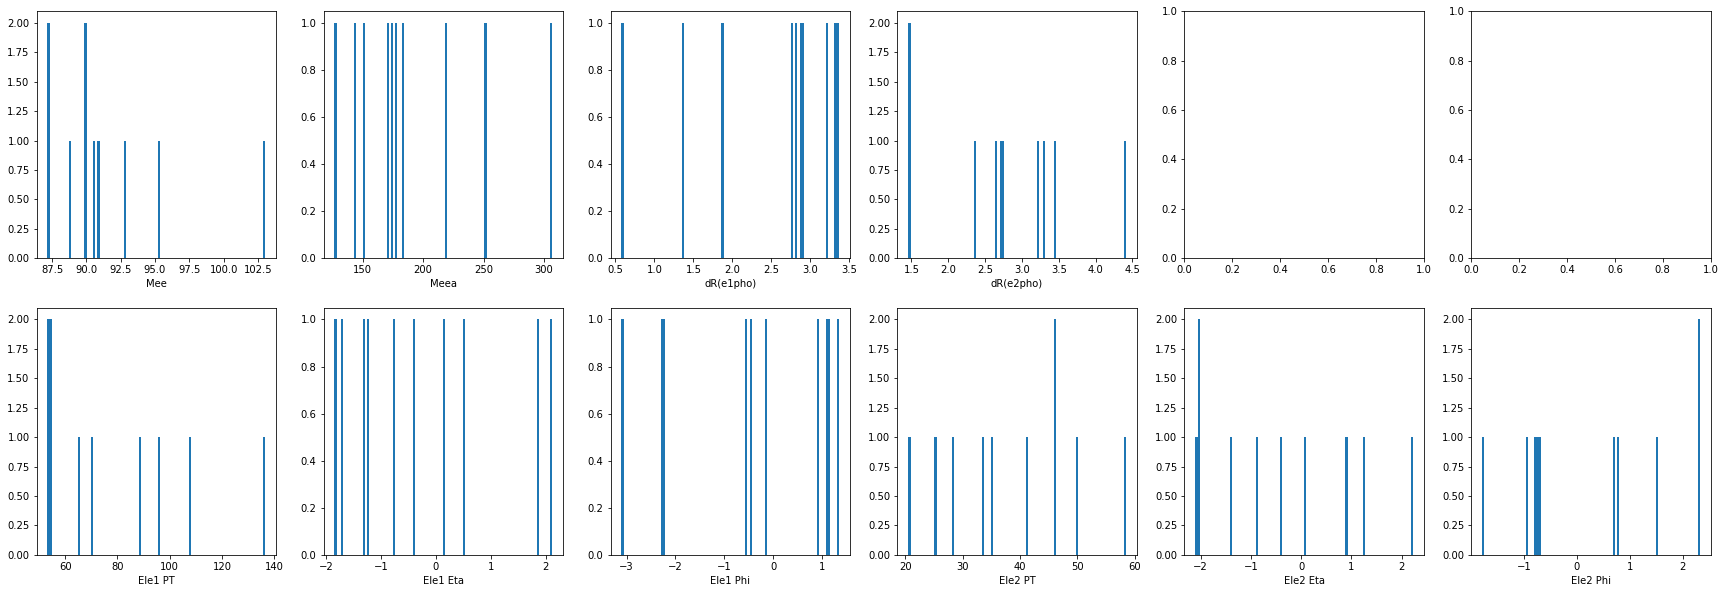

In [38]:
fig,axs = plt.subplots(2,6,figsize=(30,10))
bins=100

axs[0,0].hist(Diele_mass,bins=bins)
axs[0,0].set_xlabel('Mee')
axs[0,1].hist(eeg_mass,bins=bins)
axs[0,1].set_xlabel('Meea')
axs[0,2].hist(dR_e1pho,bins=bins)
axs[0,2].set_xlabel('dR(e1pho)')
axs[0,3].hist(dR_e2pho,bins=bins)
axs[0,3].set_xlabel('dR(e2pho)')


axs[1,0].hist(Ele1_pt,bins=bins)
axs[1,0].set_xlabel('Ele1 PT')

axs[1,1].hist(Ele1_eta,bins=bins)
axs[1,1].set_xlabel('Ele1 Eta')

axs[1,2].hist(Ele1_phi,bins=bins)
axs[1,2].set_xlabel('Ele1 Phi')

axs[1,3].hist(Ele2_pt,bins=bins)
axs[1,3].set_xlabel('Ele2 PT')

axs[1,4].hist(Ele2_eta,bins=bins)
axs[1,4].set_xlabel('Ele2 Eta')

axs[1,5].hist(Ele2_phi,bins=bins)
axs[1,5].set_xlabel('Ele2 Phi')

plt.show()